# The OperationsResearch fall-2024 problem

## Summary

The goal of project is to maximize the revenue of a factory which is producing metal alloys and sends them to markets using containers.
we have some limitations in different levels of problem which you can see in project doc.


## Pyomo formulation
We begin by importing the Pyomo package and creating a model abstract object:

In [ ]:
from pyomo.environ import *
infinity = float('inf')
model = AbstractModel(name='OR1')

The sets $Ore$, $Alloys$, $Metals$, $Factories$, $Depots$ and $Markets$ are declared abstractly using the `Set` component:

In [ ]:
model.Ore = Set()
model.Alloys = Set()
model.Metals = Set()
model.Factories = Set()
model.Depots = Set()
model.Markets = Set()

Similarly, we add parameters, the model parameters are defined abstractly using the `Param` component:

In [ ]:
M = 999999999
epsilon = 1e-9
discount_percentage = 0.05

model.min_buy_fac = Param(model.Factories,within=NonNegativeReals, default=0.0)
model.max_buy_fac = Param(model.Factories,within=NonNegativeReals, default=infinity)
model.discount_margin = Param(model.Factories, within=NonNegativeReals, default=infinity)
model.contract_cost = Param(model.Factories,within= NonNegativeReals)
model.A_comb_min = Param(model.Metals, within=NonNegativeReals, default=0.0)
model.A_comb_max = Param(model.Metals, within=NonNegativeReals, default=infinity)
model.B_comb_min = Param(model.Metals, within=NonNegativeReals, default=0.0)
model.B_comb_max = Param(model.Metals, within=NonNegativeReals, default=infinity)
model.price_of_alloy_fac = Param(model.Factories, model.Alloys, within=NonNegativeReals)
model.Max_ore = Param(model.Ore,within=NonNegativeReals)
model.Ore_cost = Param(model.Ore,within=NonNegativeReals)
model.Ore_combination = Param(model.Ore, model.Metals, within=NonNegativeReals)
model.container_cap = Param(within= NonNegativeIntegers)
model.Container_min_to_be_sent_depot = Param(model.Factories, model.Depots, within=NonNegativeIntegers)
model.Container_Max_to_be_sent_depot = Param(model.Factories, model.Depots, within=NonNegativeIntegers)
model.Container_cost_to_be_sent_depot = Param(model.Factories, model.Depots , within=NonNegativeReals)
model.depots_min_to_receive = Param(model.Depots, within=NonNegativeIntegers)
model.depots_Max_to_receive = Param(model.Depots, within=NonNegativeIntegers)
model.Container_min_to_be_sent_market = Param(model.Depots, model.Markets, within= NonNegativeIntegers)
model.Container_Max_to_be_sent_market = Param(model.Depots, model.Markets, within= NonNegativeIntegers)
model.Container_cost_to_be_sent_market = Param(model.Depots ,model.Markets, within= NonNegativeReals)
model.Max_market_demand = Param(model.Markets,model.Alloys, within= NonNegativeReals)
model.Market_price = Param(model.Markets , model.Alloys , within= NonNegativeReals)

The `within` option here is used in these parameter declarations to define expected properties of the parameters.  This information is used to perform error checks on the data that is used to initialize the parameter components.

The `Var` component is used to define the decision variables:
the `binary` is `{0,1}` to be clear.

In [ ]:
model.Z = Var(model.Ore,model.Alloys, within=NonNegativeReals)
model.F = Var(model.Ore,model.Alloys, within=NonNegativeReals)
model.A = Var(model.Ore,model.Alloys, within=NonNegativeReals)
model.C = Var(model.Ore,model.Alloys, within=NonNegativeReals) 
model.U = Var(model.Alloys,within=NonNegativeReals)
model.t = Var(model.Alloys,model.Factories,model.Depots, within=NonNegativeReals)
model.Extracted_ore = Var(model.Ore,within=NonNegativeReals) # defined as S in report
model.h = Var(model.Factories,within= Binary)
model.B = Var(model.Factories, model.Depots, within=NonNegativeIntegers)
model.g = Var(model.Alloys, model.Depots, model.Markets, within=NonNegativeReals)
model.G = Var(model.Depots, model.Markets, within= NonNegativeIntegers)
model.l = Var(model.Depots, model.Markets, within= Binary)
model.d = Var([1,2], within= Binary)
model.R = Var(model.Alloys,[1,2], within= NonNegativeReals, initialize=0)

Rule functions are used to define constraint expressions in the `Constraint` component:
here we have rule for maximum extraction of Ore:

In [ ]:
def Max_extracted_ore_rule(model,i):
    return model.Extracted_ore[i] <= model.Max_ore[i]
model.Max_extracted_ore_limit = Constraint(model.Ore,rule=Max_extracted_ore_rule)

Rule for Alloy weight limit(alloy weight is sum of metals weights in it):

In [ ]:
def Alloy_sum_rule(model,j):
    return model.U[j] == sum(model.Z[i,j] for i in model.Ore)+\
                         sum(model.C[i,j] for i in model.Ore)+\
                         sum(model.A[i,j] for i in model.Ore)+\
                         sum(model.F[i,j] for i in model.Ore)
model.Alloy_sum_limit = Constraint(model.Alloys,rule=Alloy_sum_rule)

Rule for Metals in alloys(should be less than (or equal to) extracted metals from Ore):

In [ ]:
def Metal_sum_rule_Z(model,i):
    return sum(model.Z[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Zinc']
model.Metal_sum_limit_Z = Constraint(model.Ore,rule=Metal_sum_rule_Z)

In [ ]:
def Metal_sum_rule_F(model,i):
    return sum(model.F[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Iron']
model.Metal_sum_limit_F = Constraint(model.Ore,rule=Metal_sum_rule_F)

In [ ]:
def Metal_sum_rule_C(model,i):
    return sum(model.C[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Copper']
model.Metal_sum_limit_C = Constraint(model.Ore,rule=Metal_sum_rule_C)

In [ ]:
def Metal_sum_rule_A(model,i):
    return sum(model.A[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Aluminum']
model.Metal_sum_limit_A = Constraint(model.Ore,rule=Metal_sum_rule_A)

Rule for limitation of percentage of Metals in Alloys(f is bottom limit and t is top limit):

In [ ]:
def Metal_in_alloy_rule_A_Z_f(model):
    value = sum(model.Z[i,'A'] for i in model.Ore)
    return model.A_comb_min['Zinc']*model.U['A']<=value
model.Metal_in_alloy_limit_A_Z_f = Constraint(rule=Metal_in_alloy_rule_A_Z_f)
def Metal_in_alloy_rule_A_Z_t(model):
    value = sum(model.Z[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Zinc']*model.U['A']
model.Metal_in_alloy_limit_A_Z_t = Constraint(rule=Metal_in_alloy_rule_A_Z_t)

In [ ]:
def Metal_in_alloy_rule_A_C_f(model):
    value = sum(model.C[i,'A'] for i in model.Ore)
    return model.A_comb_min['Copper']*model.U['A']<=value
model.Metal_in_alloy_limit_A_C_f = Constraint(rule=Metal_in_alloy_rule_A_C_f)
def Metal_in_alloy_rule_A_C_t(model):
    value = sum(model.C[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Copper']*model.U['A']
model.Metal_in_alloy_limit_A_C_t = Constraint(rule=Metal_in_alloy_rule_A_C_t)

In [ ]:
def Metal_in_alloy_rule_A_A_f(model):
    value = sum(model.A[i,'A'] for i in model.Ore)
    return model.A_comb_min['Aluminum']*model.U['A']<=value
model.Metal_in_alloy_limit_A_A_f = Constraint(rule=Metal_in_alloy_rule_A_A_f)
def Metal_in_alloy_rule_A_A_t(model):
    value = sum(model.A[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Aluminum']*model.U['A']
model.Metal_in_alloy_limit_A_A_t = Constraint(rule=Metal_in_alloy_rule_A_A_t)

In [ ]:
def Metal_in_alloy_rule_A_F_f(model):
    value = sum(model.F[i,'A'] for i in model.Ore)
    return model.A_comb_min['Iron']*model.U['A']<=value
model.Metal_in_alloy_limit_A_F_f = Constraint(rule=Metal_in_alloy_rule_A_F_f)
def Metal_in_alloy_rule_A_F_t(model):
    value = sum(model.F[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Iron']*model.U['A']
model.Metal_in_alloy_limit_A_F_t = Constraint(rule=Metal_in_alloy_rule_A_F_t)

In [ ]:
def Metal_in_alloy_rule_B_Z_f(model):
    value = sum(model.Z[i,'B'] for i in model.Ore)
    return model.B_comb_min['Zinc']*model.U['B']<=value
model.Metal_in_alloy_limit_B_Z_f = Constraint(rule=Metal_in_alloy_rule_B_Z_f)
def Metal_in_alloy_rule_B_Z_t(model):
    value = sum(model.Z[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Zinc']*model.U['B']
model.Metal_in_alloy_limit_B_Z_t = Constraint(rule=Metal_in_alloy_rule_B_Z_t)

In [ ]:
def Metal_in_alloy_rule_B_C_f(model):
    value = sum(model.C[i,'B'] for i in model.Ore)
    return model.B_comb_min['Copper']*model.U['B']<=value
model.Metal_in_alloy_limit_B_C_f = Constraint(rule=Metal_in_alloy_rule_B_C_f)
def Metal_in_alloy_rule_B_C_t(model):
    value = sum(model.C[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Copper']*model.U['B']
model.Metal_in_alloy_limit_B_C_t = Constraint(rule=Metal_in_alloy_rule_B_C_t)

In [ ]:
def Metal_in_alloy_rule_B_A_f(model):
    value = sum(model.A[i,'B'] for i in model.Ore)
    return model.B_comb_min['Aluminum']*model.U['B']<=value
model.Metal_in_alloy_limit_B_A_f = Constraint(rule=Metal_in_alloy_rule_B_A_f)
def Metal_in_alloy_rule_B_A_t(model):
    value = sum(model.A[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Aluminum']*model.U['B']
model.Metal_in_alloy_limit_B_A_t = Constraint(rule=Metal_in_alloy_rule_B_A_t)

In [ ]:
def Metal_in_alloy_rule_B_F_f(model):
    value = sum(model.F[i,'B'] for i in model.Ore)
    return model.B_comb_min['Iron']*model.U['B']<=value
model.Metal_in_alloy_limit_B_F_f = Constraint(rule=Metal_in_alloy_rule_B_F_f)
def Metal_in_alloy_rule_B_F_t(model):
    value = sum(model.F[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Iron']*model.U['B']
model.Metal_in_alloy_limit_B_F_t = Constraint(rule=Metal_in_alloy_rule_B_F_t)

Rule for amount of exported alloy from main Factory, it should be less than(or equal to):

In [ ]:
def Export_from_main_fac_rule(model,i):
    return model.U[i] >= sum(model.t[i,'Main',k] for k in model.Depots)
model.Export_from_main_fac_limit = Constraint(model.Alloys,rule=Export_from_main_fac_rule)

Rule of Limits of buying from factories:

In [ ]:
def buy_from_fac_rule_f(model,i):
    value = sum(sum(model.t[j,i,k] for k in model.Depots)\
                                                for j in model.Alloys)
    return model.min_buy_fac[i]*model.h[i]<=value
model.buy_from_fac_limit_f= Constraint([1,2],rule=buy_from_fac_rule_f)
def buy_from_fac_rule_t(model,i):
    value = sum(sum(model.t[j,i,k] for k in model.Depots)\
                                                for j in model.Alloys)
    return value<=model.max_buy_fac[i]*model.h[i]
model.buy_from_fac_limit_t= Constraint([1,2],rule=buy_from_fac_rule_t)

Rule of limit for Alloys in one container from Factory to Depot:

In [ ]:
def container_rule(model,i,j):
    return sum(model.t[a,i,j] for a in model.Alloys) <= model.B[i,j]*model.container_cap
model.container_limit = Constraint(model.Factories, model.Depots, rule=container_rule)

Rule of limit for transporting from fac to depots No1.:

In [ ]:
def transportation_rule_t(model,i,j):
    return model.B[i,j]<= model.Container_Max_to_be_sent_depot[i,j]*model.h[i]
model.transportation_limit_t = Constraint(model.Factories,model.Depots, rule= transportation_rule_t)
def transportation_rule_f(model,i,j):
    return model.Container_min_to_be_sent_depot[i,j]*model.h[i]<=model.B[i,j]
model.transportation_limit_f = Constraint(model.Factories,model.Depots, rule= transportation_rule_f)

Rule of limit for transporting from fac to depots No2.:

In [ ]:
def transportation_rule2(model,j):
    return inequality(model.depots_min_to_receive[j],sum(model.B[i,j] for i in model.Factories),\
                      model.depots_Max_to_receive[j])
model.transportation_limit2 = Constraint(model.Depots,rule= transportation_rule2)

Rule of limit for transporting from depots to markets:

In [ ]:
def transp_from_dep_to_marker_rule(model,i,k):
    return sum(model.t[i,j,k] for j in model.Factories) >= sum(model.g[i,k,l] for l in model.Markets)
model.transp_from_dep_to_marker_limit = Constraint(model.Alloys,model.Depots,\
                                                rule= transp_from_dep_to_marker_rule)

Rule of limits for Alloys in containers transporting from depots to markets:

In [ ]:
def container_rule2(model,i,j):
    return sum(model.g[l,i,j] for l in model.Alloys) <= model.G[i,j]*model.container_cap
model.container_limit2 = Constraint(model.Depots, model.Markets, rule=container_rule2)

Limit for containers to be sent to markets:

In [ ]:
def market_sell_rule_f(model,i,j):
    return model.Container_min_to_be_sent_market[i,j]*model.l[i,j]<=model.G[i,j]
model.market_sell_limit_f = Constraint(model.Depots,model.Markets, rule= market_sell_rule_f)
def market_sell_rule_t(model,i,j):
    return model.G[i,j]<=model.Container_min_to_be_sent_market[i,j]*model.l[i,j]
model.market_sell_limit_t = Constraint(model.Depots,model.Markets, rule= market_sell_rule_t)

Here we have maximum market demands rule:

In [ ]:
def max_market_demand_rule(model,k,i):
    return sum(model.g[i,j,k] for j in model.Depots) <= model.Max_market_demand[k,i]
model.max_market_demand_limit = Constraint(model.Markets, model.Alloys, rule= max_market_demand_rule)

The `Objective` component is used to define the revenue objective.  This component uses a rule function to construct the objective expression:

$sense=maximize$ means we want to maximize the revenue.

In [ ]:
def revenue_rule(model):
    return sum(sum(model.Market_price[m,j]*sum(model.g[j,k,m] for k in model.Depots) for j in model.Alloys) for m in model.Markets)-\
           sum(model.Extracted_ore[i]*model.Ore_cost[i] for i in model.Ore)-\
           sum(sum(model.price_of_alloy_fac[u,j]*sum(model.t[j,u,k] for k in model.Depots) for j in model.Alloys) for u in model.Factories)-\
           sum(model.h[u]*model.contract_cost[u] for u in model.Factories)-\
           sum(sum(model.Container_cost_to_be_sent_depot[i,j]*model.B[i,j] for j in model.Depots) for i in model.Factories)-\
           sum(sum(model.G[i,j]*model.Container_cost_to_be_sent_market[i,j] for j in model.Markets) for i in model.Depots)

In [ ]:
model.revenue = Objective(rule=revenue_rule, sense=maximize)

here is added constraints and adjusted revenue for ```part B```:

In [ ]:
def discount_rule_1(model,u):
    return sum(sum(model.t[j,u,k] for j in model.Alloys) for k in model.Depots)+epsilon <= model.d[u]*model.discount_margin[u] +\
                                                                                  model.discount_margin[u]

def discount_rule_2(model,u):
    return sum(sum(model.t[j,u,k] for j in model.Alloys) for k in model.Depots) >= model.discount_margin[u]*model.d[u]

def discount_rule_3(model,u,j):
    return sum(model.t[j,u,k] for k in model.Depots) >= model.R[j,u]

def discount_rule_4(model,u):
    return sum(model.R[j,u] for j in model.Alloys) <= model.d[u]*M

def revenue_rule_discount_added(model):
    return sum(sum(model.Market_price[m,j]*sum(model.g[j,k,m] for k in model.Depots) for j in model.Alloys) for m in model.Markets)-\
           sum(model.Extracted_ore[i]*model.Ore_cost[i] for i in model.Ore)-\
           sum(sum(model.price_of_alloy_fac[u,j]*sum(model.t[j,u,k] for k in model.Depots) for j in model.Alloys) for u in model.Factories)-\
           sum(model.h[u]*model.contract_cost[u] for u in model.Factories)-\
           sum(sum(model.Container_cost_to_be_sent_depot[i,j]*model.B[i,j] for j in model.Depots) for i in model.Factories)-\
           sum(sum(model.G[i,j]*model.Container_cost_to_be_sent_market[i,j] for j in model.Markets) for i in model.Depots)+\
           sum(sum(discount_percentage*model.R[j,u]*model.price_of_alloy_fac[u,j] for u in [1,2]) for j in model.Alloys)

def apply_discount_rule():
    model.discount_limit_1 = Constraint([1,2],rule=discount_rule_1)
    model.discount_limit_2 = Constraint([1,2],rule=discount_rule_2)
    model.discount_limit_3 = Constraint([1,2],model.Alloys,rule=discount_rule_3)
    model.discount_limit_4 = Constraint([1,2],rule=discount_rule_4)
    model.revenue = Objective(rule=revenue_rule_discount_added, sense=maximize)


## model data
since we have made an abstract model, we can add the data after creating model, to see the data we are feeding the model

execute command below or have a look at params.dat:

In [6]:
!cat params.dat

set Alloys:=
       A        
       B;

param: Factories:         min_buy_fac  discount_margin  max_buy_fac     contract_cost:=
       1                  2000         2500             5000            120
       2                  2500         3000             6000            90
       Main               0            .                .               0   ;

param: Depots:         depots_min_to_receive  depots_Max_to_receive :=
       Tehran          20                     65
       Isfahan         30                     70   ;

param container_cap:= 100;

set Markets:=
       Mashhad 
       Kerman 
       Ahvaz    
       Tabriz  ;

param: Metals:       A_comb_min   A_comb_max    B_comb_min   B_comb_max :=
       Iron          0            0.25          0.45         0.70
       Aluminum      0.55         1             0            0.70
       Zinc          0            0.8           0            1
       Copper        0            1             0.35         1  ;

param: Ore:           

## Solution
To get the result of a problem,you can execute the command below:

make sure to replace `-problem-number` with correct number, use porblem-dict.

results are also saved in `results.yaml`

In [ ]:
!python model_runner.py -problem-number

or use code below in cases of having plots to be shown:

In [ ]:
%matplotlib inline
%run model_runner.py -problem-number

this is problem-dictionary


`{
    '-a':'الف',
    '-b':'ب',
    '-c':'ج',
    '-d':'د',
    '-e':'ه',
    '-f':'و',
    '-g':'ز',
    '-h':'ح',
    '-i':'ط'
}`

for example you can execute the code below to see results of problem الف:

### Problem A

In [6]:
!python model_runner.py -a

results for problem: -a

Problem: 
- Name: unknown
  Lower bound: 1037982.72727273
  Upper bound: 1037982.72727273
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 82
  Number of nonzeros: 304
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 33
      Number of created subproblems: 33
  Error rc: 0
  Time: 0.010471343994140625
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Model OR1

  Variables:
    Z : Size=6, Index=Ore*Alloys
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        (1, 'A') :     0 :            140.0 :  None : False : False : NonNegativeReals
        (1, 'B') :     0 :              0.0 :  None : False : False : NonNegativeReals
        (2, 'A') :     0 :            150.0 :  None : False : False : NonNegativeReals
        (2, 'B') :     0 :              0.0 :  None : False : False : NonNegat

#### Explanation

In the report above, we have three parts, `variables`, `objective` and `constraints`, you can see value of variables in `Value` column of variables section, and as you see, value of objective(revenue) is equal to `1037982.72727273`

### Problem B

In [5]:
!python model_runner.py -b

results for problem: -b
'pyomo.core.base.objective.ScalarObjective'>) on block OR1 with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().

Problem: 
- Name: unknown
  Lower bound: 1107067.57575758
  Upper bound: 1107067.57575758
  Number of objectives: 1
  Number of constraints: 107
  Number of variables: 88
  Number of nonzeros: 342
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 29
      Number of created subproblems: 29
  Error rc: 0
  Time: 0.010447025299072266
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Model OR1

  Variables:
    Z : Size=6, Index=Ore*Alloys
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        (1, 'A') :     0 : 38.6666666666667 :  None : False : False : Non

#### explanation

In the report above, we have three parts, `variables`, `objective` and `constraints`, you can see value of variables in `Value` column of variables section, and as you see, value of objective(revenue) is equal to `1107067.57575758`

you can see result file using code below:

In [11]:
!cat results.yaml

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1107067.57575758
  Upper bound: 1107067.57575758
  Number of objectives: 1
  Number of constraints: 107
  Number of variables: 88
  Number of nonzeros: 342
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 29
      Number of created subproblems: 29
  Error rc: 0
  Time: 0.012421846389770508
# ----------------------------------------------------------
#   Solution Information
# -------

## Sensitivity Analysis

here we produce sensitivity analysis, be aware that, here we should eliminate binaries and integers to make sensitivity analysis, because glpk does not work with MIP(Mixed Integer Problem) problems, we will use this file later on.

In [30]:
!glpsol -m model.lp --lp --ranges sensit.sen

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 -m model.lp --lp --ranges sensit.sen
Reading problem data from 'model.lp'...
97 rows, 82 columns, 304 non-zeros
731 lines were read
GLPK Simplex Optimizer 5.0
97 rows, 82 columns, 304 non-zeros
Preprocessing...
89 rows, 82 columns, 286 non-zeros
Scaling...
 A: min|aij| =  5.000e-02  max|aij| =  6.000e+03  ratio =  1.200e+05
GM: min|aij| =  5.953e-01  max|aij| =  1.680e+00  ratio =  2.822e+00
EQ: min|aij| =  3.704e-01  max|aij| =  1.000e+00  ratio =  2.700e+00
Constructing initial basis...
Size of triangular part is 89
      0: obj =  -0.000000000e+00 inf =   7.935e+02 (2)
      8: obj =  -2.613400000e+05 inf =   0.000e+00 (0)
*    95: obj =   1.040631552e+06 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (173261 bytes)
Write sensitivity analysis report to 'sensit.sen'...


### Sensit file
to see sensit.sen, we run code below:

In [9]:
!cat sensit.sen

GLPK 5.0  - SENSITIVITY ANALYSIS REPORT                                                                         Page   1

Problem:    
Objective:  revenue = 1660813.37 (MAXimum)

   No. Row name     St      Activity         Slack   Lower bound       Activity      Obj coef  Obj value at Limiting
                                          Marginal   Upper bound          range         range   break point variable
------ ------------ -- ------------- ------------- -------------  ------------- ------------- ------------- ------------
     1 c_u_Max_extracted_ore_limit(1)_
                    NU     560.00000        .               -Inf      471.42857    -209.57253   1.64225e+06 c_u_max_market_demand_limit(Mashhad_B)_
                                         209.57253     560.00000      628.57143          +Inf   1.67518e+06 g(B_Isfahan_Mashhad)

     2 c_u_Max_extracted_ore_limit(2)_
                    NU    1000.00000        .               -Inf      896.66667    -325.65010   1.62716e+06 c_

### Analysis D
here in problem D, we wanna see how much change we should make in cost of converting Ore to Alloy to stop Main fac from producing product: 


#### Code for Analysis D
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.


In [ ]:
def d():
        for cost in range(300, 400):
            instance.Price_of_ore_to_alloy = cost
            solver.solve(instance)
            print(f"Price of ore to alloy: {instance.Price_of_ore_to_alloy()}, Use Main?: {instance.h['Main']()}")


#### Output
run the command below to see the result:

In [5]:
!python model_runner.py -d

results for problem: -d
Price of ore to alloy: 300, Use Main?: 1.0
Price of ore to alloy: 301, Use Main?: 1.0
Price of ore to alloy: 302, Use Main?: 1.0
Price of ore to alloy: 303, Use Main?: 1.0
Price of ore to alloy: 304, Use Main?: 1.0
Price of ore to alloy: 305, Use Main?: 1.0
Price of ore to alloy: 306, Use Main?: 1.0
Price of ore to alloy: 307, Use Main?: 1.0
Price of ore to alloy: 308, Use Main?: 1.0
Price of ore to alloy: 309, Use Main?: 1.0
Price of ore to alloy: 310, Use Main?: 1.0
Price of ore to alloy: 311, Use Main?: 1.0
Price of ore to alloy: 312, Use Main?: 1.0
Price of ore to alloy: 313, Use Main?: 1.0
Price of ore to alloy: 314, Use Main?: 1.0
Price of ore to alloy: 315, Use Main?: 1.0
Price of ore to alloy: 316, Use Main?: 1.0
Price of ore to alloy: 317, Use Main?: 1.0
Price of ore to alloy: 318, Use Main?: 1.0
Price of ore to alloy: 319, Use Main?: 1.0
Price of ore to alloy: 320, Use Main?: 1.0
Price of ore to alloy: 321, Use Main?: 1.0
Price of ore to alloy: 322, Us

#### Explanation
As we see from the output, after cost of `352` the main factory will not produce any Alloy.

### Analysis E
Here we wanna see how to change contract cost to see when a factory becomes unworthy to have contract with,

first we should be aware that for `Fac2`, we won't have contract in any cost, so we do analysis just for `Fac1`:


#### Code for Analysis E
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.


In [ ]:
def e():
        instance.Price_of_ore_to_alloy = 0
        for cost in range(400, 550):
            instance.contract_cost[1] = 100 * cost
            solver.solve(instance)
            print(f"Fac1 contract cost: {instance.contract_cost[1]()}, Buy from Fac1: {instance.h[1]()}, Buy from Fac2: {instance.h[2]()}")


#### Output
run the command below to see the result:

In [3]:
!python model_runner.py -e

results for problem: -e
Fac1 contract cost: 110000, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110100, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110200, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110300, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110400, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110500, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110600, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110700, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110800, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 110900, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 111000, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 111100, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 111200, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 111300, Buy from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 111400, Buy from F

#### Explanation
As we see, in contract cost of `119600` we won't have contract with `Fac1` and instead we will buy from `Fac2`,

if we analyzed this for `Fac2`, 'Buy from Fac2' was always 0, that is because costs of buying and sending from `Fac2` are higher.

### Analysis F


#### Output

The part related to problem is extracted from sensit.sen:


``` res
  No. Column name  St      Activity      Obj coef   Lower bound       Activity      Obj coef  Obj value at Limiting
                                          Marginal   Upper bound          range         range   break point variable
------ ------------ -- ------------- ------------- -------------  ------------- ------------- ------------- ------------

    22 t(A_1_Tehran)
                    NL        .         -375.00000        .              .               -Inf   1.10712e+06 R(A_1)
                                         -12.25000          +Inf         .         -362.75000   1.10712e+06 t(A_Main_Tehran)

    23 t(A_1_Isfahan)
                    NL        .         -375.00000        .              .               -Inf   1.10712e+06 R(A_1)
                                         -12.25000          +Inf      298.18182    -362.75000   1.10347e+06 g(B_Isfahan_Kerman)

    24 t(A_2_Tehran)
                    NL        .         -390.00000        .              .               -Inf   1.10712e+06 R(A_2)
                                          -7.94000          +Inf         .         -382.06000   1.10712e+06 c_u_buy_from_fac_limit_t(2)_

    25 t(A_2_Isfahan)
                    NL        .         -390.00000        .              .               -Inf   1.10712e+06 R(A_2)
                                          -7.50000          +Inf         .         -382.50000   1.10712e+06 t(B_2_Isfahan)

    26 t(B_1_Tehran)
                    BS    2034.90909    -520.00000        .          1956.60606    -520.00000   1.10712e+06 c_u_transportation_limit_t(1_Tehran)_
                                            .               +Inf     2118.30303    -519.96000   1.10721e+06 c_u_buy_from_fac_limit_t(1)_

    27 t(B_1_Isfahan)
                    BS    1356.60606    -520.00000        .          1273.21212    -520.04000   1.10707e+06 c_u_buy_from_fac_limit_t(1)_
                                            .               +Inf     1434.90909    -520.00000   1.10712e+06 c_u_transportation_limit_t(1_Tehran)_

    28 t(B_2_Tehran)
                    NL        .         -540.00000        .              .               -Inf   1.10712e+06 c_u_buy_from_fac_limit_f(2)_
                                           -.44000          +Inf         .         -539.56000   1.10712e+06 c_u_buy_from_fac_limit_t(2)_

    29 t(B_2_Isfahan)
                    BS        .         -540.00000        .              .         -540.44000   1.10712e+06 t(B_2_Tehran)
                                            .               +Inf         .         -520.86400   1.10712e+06 c_u_discount_limit_4(2)_

```

#### Explanation

To make it clear, information showed above is related to variable $t$, which shows how much alloy we send to which depots in what amount(value is showed in `Activity` column).

The $NL$ shows that variable is noneBasic, and $BS$ shows that variable is Basic.

The `Obj coef` column shows the coefficient of that variable, it it obvious that for $t[A,F,D]$ it is equal to $priceOfAlloyFac[A,F]$,
the `Obj coef Range` shows that in what coef range the $BS$ does not change, we will use this to determine the range of coefficients:

to buy `A` from `Fac1`:
    the coef range is in range (362.750 , inf) and also (362.750 , inf),
    so it is in range $(362.750 , inf)$

to buy `A` from `Fac2`:
    the coef range is in range (382.060 , inf) and also (382.50 , inf),
    so it is in range $(382.50 , inf)$
    
to buy `B` from `Fac1`:
    the coef range is in range (519.96 , 520.0) and also (520.0, 520.4),
    so it is in range $(520.0 , 520.0)$
    
to buy `B` from `Fac2`:
    the coef range is in range (539.56 , inf) and also (520.864 , 540.44),
    so it is in range $(539.56 , 540.44)$
    

### Analysis G
Here we wanna see how the revenue changes by changing a coefficient and a right-hand side. 

we have two parts, first we analyze the problem considering values of coefficients change separately, then we analyze the problem considering values of coefficients can change together.

in first part, we choose `depots_min_to_receive` for `Tehran` as right-hand side value and `Container_cost_to_be_sent_depot` for `MainFac` to `Tehran` as our coefficient.

in second part, For right-hand side, we chose `Max_ore` of `Fac2` and for constraint coefficient we chose `price_of_alloy_fac` for Alloy `B` in `Fac2` and plot in 3D.


#### Code for Analysis G
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.

In [ ]:
# first part right-hand side.
def g_2():
    depot_Tehran_min_to_recieve_change_list = []
    revenue_depend_on_tehran_min_to_recieve = []

    for capacity in range(20,65):
        instance.depots_min_to_receive['Tehran'] = capacity
        solver.solve(instance)
        revenue = instance.revenue()
        print(f"Tehran minimum receive: {capacity}, Revenue {instance.revenue()}, buy from Fac2: {instance.h[2]()}") 
        revenue_depend_on_tehran_min_to_recieve.append(revenue)
        depot_Tehran_min_to_recieve_change_list.append(capacity)
    depot_Tehran_min_to_recieve_change_np = np.array(depot_Tehran_min_to_recieve_change_list)
    revenue_depend_on_tehran_max_to_recieve_np = np.array(revenue_depend_on_tehran_min_to_recieve)

    plt.xlabel("Tehran minimum receive")
    plt.ylabel("Revenue")
    plt.plot(depot_Tehran_min_to_recieve_change_np, revenue_depend_on_tehran_max_to_recieve_np)
    plt.show()


In [ ]:
#first part coefficient.
def g_3():
    Container_cost_to_be_sent_depot_list=[]
    revenue_changing_Container_cost_to_be_sent_depot_list = []

    for cost in range (100):
        new_cost =  50*cost
        instance.Container_cost_to_be_sent_depot['Main', 'Tehran'] = new_cost
        solver.solve(instance)
        revenue = instance.revenue()
        print(f"Container cost from Main to Tehran: {new_cost}, Revenue{instance.revenue()}")
        Container_cost_to_be_sent_depot_list.append(new_cost)
        revenue_changing_Container_cost_to_be_sent_depot_list.append(revenue)
        
    Container_cost_to_be_sent_depot_np = np.array(Container_cost_to_be_sent_depot_list)
    revenue_changing_Container_cost_to_be_sent_depot_np = np.array(revenue_changing_Container_cost_to_be_sent_depot_list)


    plt.plot(Container_cost_to_be_sent_depot_np, revenue_changing_Container_cost_to_be_sent_depot_np)

    plt.xlabel("Container cost Main->Tehran")
    plt.ylabel("Revenue")
    plt.show()


In [ ]:
#second part, both coefficient and right-hand side.
def g():
    price_of_alloy_fac_2_alloy_b_set = np.arange(0,(instance.price_of_alloy_fac[2,'B']())*3,1)#for c
    max_ore_2_set = np.arange(0,(instance.Max_ore[2]()),100)#for b
    object = np.zeros(shape=(len(price_of_alloy_fac_2_alloy_b_set),len(max_ore_2_set)))
    for i,V1 in enumerate(price_of_alloy_fac_2_alloy_b_set):
        for j,V2 in enumerate(max_ore_2_set):
            instance.price_of_alloy_fac[2,'B'] = V1
            instance.Max_ore[2] = V2
            solver.solve(instance)
            object[i,j] = instance.revenue()

    fig = go.Figure(data=[go.Surface(z=object, x=max_ore_2_set, y=price_of_alloy_fac_2_alloy_b_set)])
    fig.update_layout(title='3D Surface Plot', autosize=True,
                    scene=dict(
                        xaxis_title='maximum of extractable ore number 2',
                        yaxis_title='price of alloy b from factory 2',
                        zaxis_title='Object'))
    fig.show()
    plt.show()#?


#### Output

run the command below to see the result:

results for problem: -g
Tehran minimum receive: 20, Revenue 1107067.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 21, Revenue 1107067.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 22, Revenue 1107067.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 23, Revenue 1107067.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 24, Revenue 1107067.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 25, Revenue 1106887.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 26, Revenue 1106707.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 27, Revenue 1106527.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 28, Revenue 1106347.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 29, Revenue 1106167.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 30, Revenue 1105987.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 31, Revenue 1105807.5757575764, buy from Fac2: 0.0
Tehran minimum receive: 32, Revenue 1105627.5757575764, buy from Fac2: 0.0
T

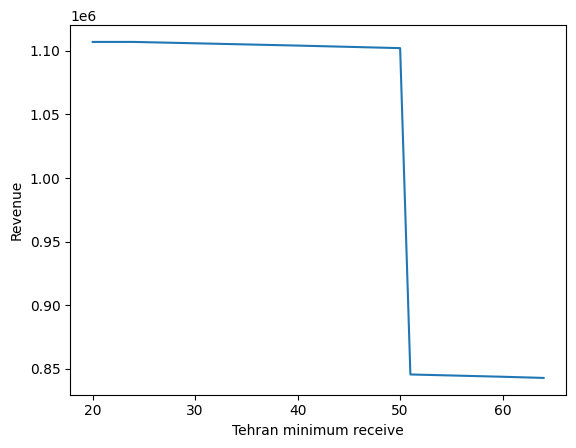

Container cost from Main to Tehran: 0, Revenue846755.0
Container cost from Main to Tehran: 50, Revenue845755.0
Container cost from Main to Tehran: 100, Revenue844755.0
Container cost from Main to Tehran: 150, Revenue843755.0
Container cost from Main to Tehran: 200, Revenue842755.0
Container cost from Main to Tehran: 250, Revenue841925.0
Container cost from Main to Tehran: 300, Revenue841475.0
Container cost from Main to Tehran: 350, Revenue841025.0
Container cost from Main to Tehran: 400, Revenue840575.0
Container cost from Main to Tehran: 450, Revenue840125.0
Container cost from Main to Tehran: 500, Revenue839675.0
Container cost from Main to Tehran: 550, Revenue839225.0
Container cost from Main to Tehran: 600, Revenue838775.0
Container cost from Main to Tehran: 650, Revenue838325.0
Container cost from Main to Tehran: 700, Revenue837875.0
Container cost from Main to Tehran: 750, Revenue837425.0
Container cost from Main to Tehran: 800, Revenue836975.0
Container cost from Main to Tehran

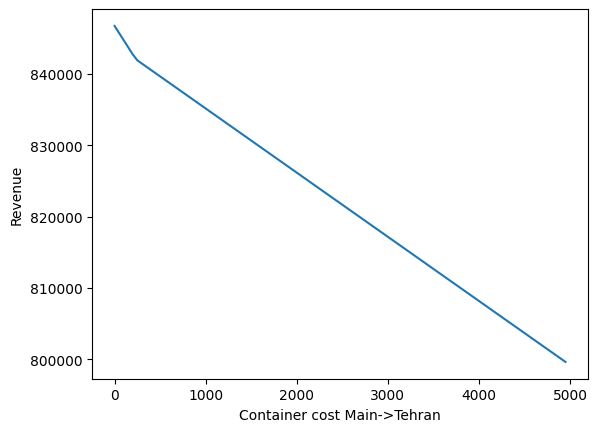

no results saved.


<Figure size 640x480 with 0 Axes>

In [4]:
%matplotlib inline
%run model_runner.py -g

the result for g() will be a html output in your browser, because the code takes long to generate output page, some images of output are shown below.

#### Explanation
In first output, we have revenue based on `Depot_min_to_receive` of `Tehran`, as we see, the revenue is constantly reducing, and after a point when `Fac2` enters the equation(minimum receive of 51), we will have a huge amount of reduce in revenue, which is because of having a floor of buying Alloy from `Fac2`.


In second output, we have revenue based on cost of sending container from `MainFac` to `Tehran`.
as we see and as expected, as the container cost increases, the revenue decreases constantly.


In third output we see that as the `price_of_alloy_fac` for Alloy `B` in `Fac2` increases, the revenue decreases and as the `Max_ore` of `Fac2` increases, the revenue increases, which is expected.

### Analysis H
we have three parts, first analyze for cost be 10 percent higher and lower.

and in second and third part we have costs range between 10 percent lower and 10 percent higher, for this parts, we chose `Container_cost_to_be_sent_depot` of `Fac1` to `Isfahan` and `Container_cost_to_be_sent_market` of `Isfahan->Mashhad` as variables, and we analyze them separately.

#### Code for Analysis H
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.

In [ ]:
def h():
    # Increase all prices
    solver.solve(instance)
    previous_revenue = instance.revenue()

    factories_list = instance.Factories()
    depots_list = instance.Depots()
    Markets_list = instance.Markets()

    for factory in factories_list:
        for depot in depots_list:
            instance.Container_cost_to_be_sent_depot[factory, depot] = 110 / 100 * instance.Container_cost_to_be_sent_depot[factory, depot]()

    for depot in depots_list:
        for market in Markets_list:
            instance.Container_cost_to_be_sent_market[depot, market] = 110 / 100 * instance.Container_cost_to_be_sent_market[depot, market]()

    solver.solve(instance)
    new_revenue = instance.revenue()
    print(f'For a 10% increase in costs, previous revenue is {previous_revenue} and new revenue is {new_revenue}')

    # Decrease all prices
    instance = model.create_instance(data=data) 
    solver.solve(instance)
    previous_revenue = instance.revenue()

    for factory in factories_list:
        for depot in depots_list:
            instance.Container_cost_to_be_sent_depot[factory, depot] = (90 / 100) * instance.Container_cost_to_be_sent_depot[factory, depot]()

    for depot in depots_list:
        for market in Markets_list:
            instance.Container_cost_to_be_sent_market[depot, market] = (90 / 100) * instance.Container_cost_to_be_sent_market[depot, market]()

    solver.solve(instance)
    new_revenue = instance.revenue()
    print(f'For a 10% reduction in costs, previous revenue is {previous_revenue} and new revenue is {new_revenue}')


In [ ]:
def h_1():
    # Single price analysis: shipping from factory 1 to depot Isfahan
    instance = model.create_instance(data=data) 
    Container_cost_to_be_sent_1_to_Isfahan = []
    revenue_changing_Container_cost_to_be_sent_1_to_Isfahan = []

    the_least_cost = instance.Container_cost_to_be_sent_depot[1, 'Isfahan']() * (90 / 100)
    cost_step = instance.Container_cost_to_be_sent_depot[1, 'Isfahan']() / 100

    for cost in range(21):
        new_cost = cost * cost_step + the_least_cost
        instance.Container_cost_to_be_sent_depot[1, 'Isfahan'] = new_cost
        solver.solve(instance)
        revenue = instance.revenue()
        Container_cost_to_be_sent_1_to_Isfahan.append(new_cost)
        revenue_changing_Container_cost_to_be_sent_1_to_Isfahan.append(revenue)

    Container_cost_to_be_sent_1_to_Isfahan_np = np.array(Container_cost_to_be_sent_1_to_Isfahan)
    revenue_changing_Container_cost_to_be_sent_1_to_isfahan_np = np.array(revenue_changing_Container_cost_to_be_sent_1_to_Isfahan)

    plt.plot(Container_cost_to_be_sent_1_to_Isfahan_np, revenue_changing_Container_cost_to_be_sent_1_to_isfahan_np)
    plt.show()

In [ ]:
def h_2():
    # Single price analysis: shipping from depot Isfahan to Mashhad
    instance = model.create_instance(data=data) 
    Container_cost_to_be_sent_isfahan_to_mashhad = []
    revenue_changing_Container_cost_to_be_sent_isfahan_to_mashhad = []

    the_least_cost = instance.Container_cost_to_be_sent_market['Isfahan', 'Mashhad']() * (90 / 100)
    cost_step = instance.Container_cost_to_be_sent_market['Isfahan', 'Mashhad']() / 100

    for cost in range(21):
        new_cost = cost * cost_step + the_least_cost
        instance.Container_cost_to_be_sent_market['Isfahan', 'Mashhad'] = new_cost
        solver.solve(instance)
        revenue = instance.revenue()
        Container_cost_to_be_sent_isfahan_to_mashhad.append(new_cost)
        revenue_changing_Container_cost_to_be_sent_isfahan_to_mashhad.append(revenue)

    Container_cost_to_be_sent_Isfahan_to_mashhad_np = np.array(Container_cost_to_be_sent_isfahan_to_mashhad)
    revenue_changing_Container_cost_to_be_sent_isfahan_to_mashhad_np = np.array(revenue_changing_Container_cost_to_be_sent_isfahan_to_mashhad)

    plt.plot(Container_cost_to_be_sent_Isfahan_to_mashhad_np, revenue_changing_Container_cost_to_be_sent_isfahan_to_mashhad_np)
    plt.show()


#### Output

run the command below to see the result:

results for problem: -h
1107067.5757575764
For a 10% increase in costs, previous revenue is 1107067.5757575764 and new revenue is 1105486.5757575764
For a 10% reduction in costs, previous revenue is 1107067.5757575764 and new revenue is 1108648.5757575764


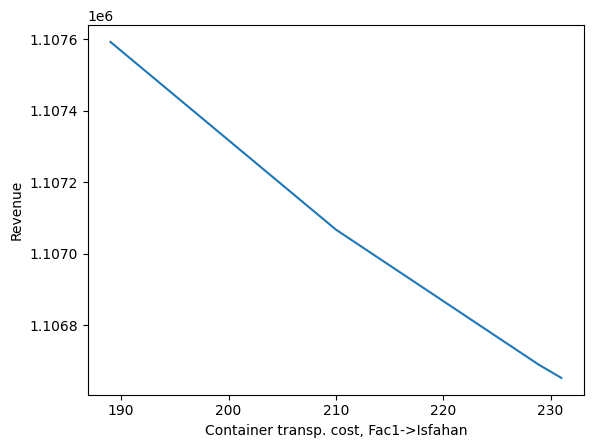

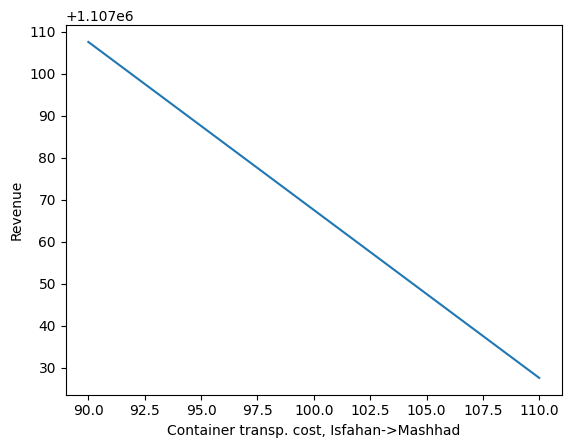

no results saved.


<Figure size 640x480 with 0 Axes>

In [13]:
%matplotlib inline
%run model_runner.py -h


#### Explanation

For first part, we see that in case of cost being increased 10 percent, the `revenue` goes from `1107067.5757575764` to `1105486.5757575764`, that shows we have `1581` **less** revenue in this case.

if we decrease costs for 10 percent, the `revenue` goes from `1107067.5757575764` to `1108648.5757575764`, that shows we have made `1581` **more** revenue in this case.

For second part, in first graph we see that by increasing `Container_cost_to_be_sent_depot[1, 'Isfahan']` in the desired range, the revenue **decreases**, which is expected,

and in second graph, by increasing `Container_cost_to_be_sent_market['Isfahan', 'Mashhad']` in the desired range, the revenue **decreases**, which is expected.

### Analysis I

here we wanna see after adding `Abadan` as a new `Market`, in what prices for `Alloys` `A` and `B`, it is worthy to sell Alloy in the matket.



#### Code for Analysis I
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.

In [ ]:
def i():
    print(list(instance.Markets))
    for p in range(300,500,5):
        instance.sell_prices_Abadan['A'] = p
        solver.solve(instance)
        print(f"Price of A: {p}, Sell A? {sum(instance.Abadan_Alloys[i,'A']() for i in instance.Depots)}")
    instance.sell_prices_Abadan['A'] = 0
    for p in range(300,500,5):
        instance.sell_prices_Abadan['B'] = p
        solver.solve(instance)
        print(f"Price of B: {p}, Sell B? {sum(instance.Abadan_Alloys[i,'B']() for i in instance.Depots)}")



#### Output

run the command below to see the result:

In [12]:
!python model_runner.py -i

results for problem: -i
for A -------------
Price of A: 300, Sell A? 0.0
Price of A: 305, Sell A? 0.0
Price of A: 310, Sell A? 0.0
Price of A: 315, Sell A? 0.0
Price of A: 320, Sell A? 0.0
Price of A: 325, Sell A? 0.0
Price of A: 330, Sell A? 0.0
Price of A: 335, Sell A? 0.0
Price of A: 340, Sell A? 0.0
Price of A: 345, Sell A? 0.0
Price of A: 350, Sell A? 800.0
Price of A: 355, Sell A? 837.857142857143
Price of A: 360, Sell A? 2400.0
Price of A: 365, Sell A? 2423.030303029303
Price of A: 370, Sell A? 2423.030303029303
Price of A: 375, Sell A? 6400.0
Price of A: 380, Sell A? 6423.0303030293
Price of A: 385, Sell A? 6423.0303030293
Price of A: 390, Sell A? 6423.0303030293
Price of A: 395, Sell A? 6423.0303030293
Price of A: 400, Sell A? 6423.0303030293
Price of A: 405, Sell A? 6423.030303029311
Price of A: 410, Sell A? 6423.030303029311
Price of A: 415, Sell A? 6423.030303029311
Price of A: 420, Sell A? 6423.0303030293
Price of A: 425, Sell A? 6423.030303029311
Price of A: 430, Sell A? 

#### Explanation

As we see, for `Alloy` `A` to be sold in `Abadan`, we should have a selling price above `350`,

and for `B` to be sold, we should have a price above `500`, higher price for B is because prices in other markets are higher for B, thus we should sell B in Abadan for higher price to take some share of other markets which are currently profitable.